# Introduction

This project aims to build a convolutional neural network for multiclass image classification from scratch using numpy. Broadly, this is an extension of my [previous project](https://github.com/Shmuley322/multilayer-perceptron-on-MNIST) and consequently I tried  making up for the general shortcomings of my previous neural net in addition to moving up from MLP to CNN. 

Outline:
- I first describe the network
- Then I take the dataset from the [Digit Recognizer Kaggle Challenge](https://www.kaggle.com/competitions/digit-recognizer) to train my CNN
- After that I make a prediction on the test data and submit it for evaluation
- Finally, I discuss the problems I faced during creation of this network and whether I was able to improve compared to the previous project

This notebook uses my network as a module, the source code for which can be found in the corresponding folder. 

# Network description

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from my_cnn.CNN import Classifier

Classifier is a CNN that may consist of any number and sequence of convolutional, max pooling and fully connected linear layers. All of the layers are connected sequentially. Initially the network supported multichannel image processing, however training was unreasonably slow so I decided to limit the network's functionality to single channel since my aim is mainly to demonstrate the concept. Following is a description of each layer in detail: 

Convolutional layer:
- supports any number of kernels
- activated with ReLU
- performs convolution with a square kernel, 0 padding and stride 1

Max pooling layer:
- performs max pooling with a square kernel, 0 padding and stride 1
- does not learn

Linear layer: 
- number of neurons is equal to the product of dimensions of an output of a reduction of previous layers, in other words it is fully connected with neurons of a previous layer
- activated with softmax

Loss function is cross-entropy. 

Next is a demonstration of convolutional and pooling layers in action

In [2]:
from PIL import Image

from my_cnn.layers import Convolutional, MaxPooling
from utils.plotting import plot_multiple, plot_metrics

In [3]:
n_kernels = 4
conv_layer = Convolutional(n_kernels, 6)
pool_layer = MaxPooling(4)

Let's run this grayscale [image](https://www.researchgate.net/profile/Rizwan-Usman-2/publication/266200280/figure/fig1/AS:392033165430784@1470479398065/Original-image-256x256.png) through the layers and see how it is processed

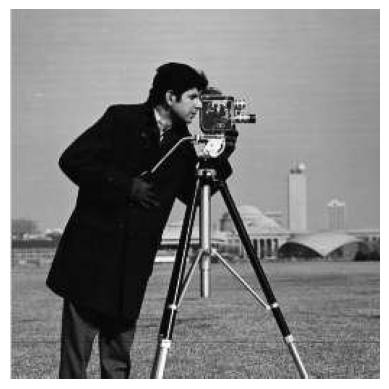

In [4]:
img = np.asarray(Image.open('data/example.jpg'))
plt.axis('off')
plt.imshow(img, cmap='gray')

Convolution:

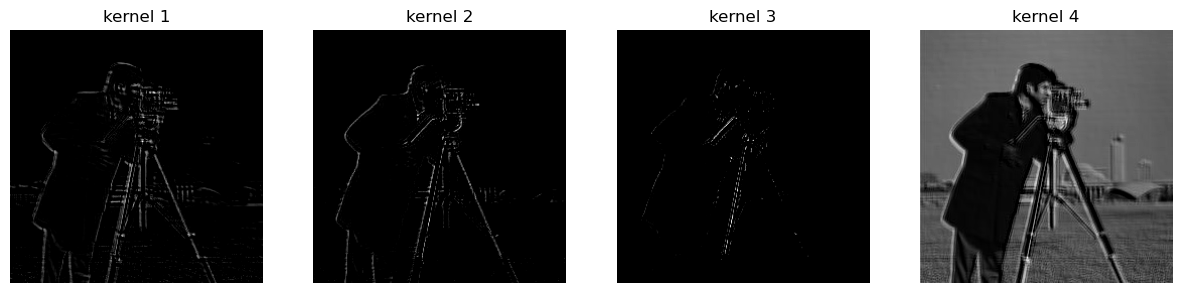

In [5]:
conv_out = conv_layer(img)
plot_multiple(conv_out, shared_title='kernel', figsize=(15,10))

Max pooling after convolution:

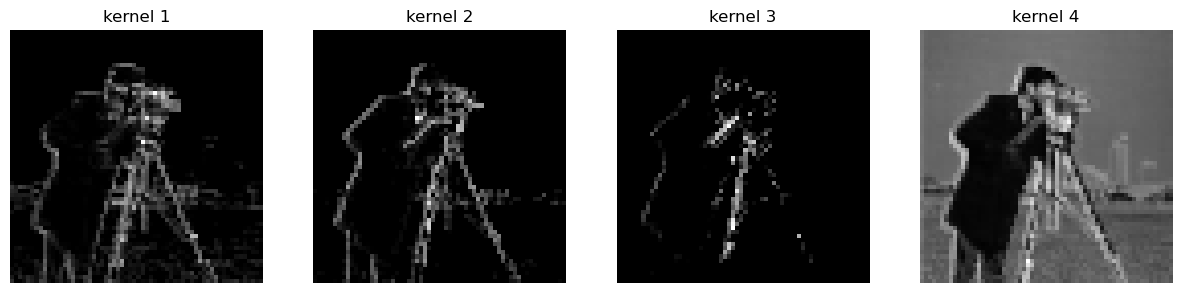

In [6]:
pool_out = pool_layer(conv_out)
plot_multiple(pool_out, shared_title='kernel', figsize=(15,10))

Max pooling without convolution:

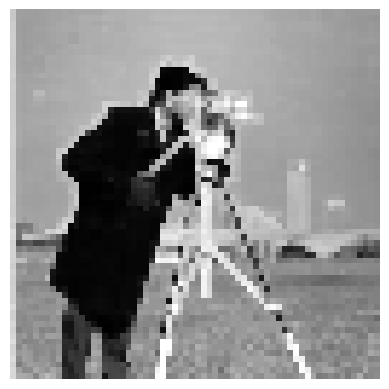

In [7]:
pool_no_convolve = pool_layer(img.reshape(*img.shape, 1))
plt.axis('off')
plt.imshow(pool_no_convolve, cmap='gray')

# Model initialization and training

Import the data and do some preprocessing

In [8]:
train_data = pd.read_csv('data/train.csv')
y_train = train_data['label'].astype(np.int8)
X_train = train_data.drop(['label'], axis=1).to_numpy().reshape((len(train_data), 28, 28))
X_train = (X_train / 255).astype(np.float32)

The classifier will consists of a convolutional layer with 10 6x6 kernels, a max pooling layer with a 4x4 kernel and a linear layer with an output size of 10

In [9]:
architecture = 'conv pool lin'
n_classes = len(set(y_train))
n_kernels = 10
conv_kernel_size = 6
pool_kernel_size = 4
input_size = X_train[0].shape

layer_params = [(n_kernels, conv_kernel_size), (pool_kernel_size,), (n_classes)]

Initialize the model and train it

In [10]:
cfr = Classifier(architecture, layer_params, n_classes, input_size)
cfr.fit(X_train, y_train, learning_rate=1e-3, n_epochs=10)

Epoch 1/10, sample 41999/42000, loss 0.50976
Loss: 0.510	 balanced accuracy on train: 0.845
Epoch 2/10, sample 41999/42000, loss 0.16334
Loss: 0.163	 balanced accuracy on train: 0.952
Epoch 3/10, sample 41999/42000, loss 0.12499
Loss: 0.125	 balanced accuracy on train: 0.963
Epoch 4/10, sample 41999/42000, loss 0.10678
Loss: 0.107	 balanced accuracy on train: 0.968
Epoch 5/10, sample 41999/42000, loss 0.09533
Loss: 0.095	 balanced accuracy on train: 0.971
Epoch 6/10, sample 41999/42000, loss 0.08712
Loss: 0.087	 balanced accuracy on train: 0.974
Epoch 7/10, sample 41999/42000, loss 0.08073
Loss: 0.081	 balanced accuracy on train: 0.976
Epoch 8/10, sample 41999/42000, loss 0.07564
Loss: 0.076	 balanced accuracy on train: 0.978
Epoch 9/10, sample 41999/42000, loss 0.07153
Loss: 0.072	 balanced accuracy on train: 0.979
Epoch 10/10, sample 41999/42000, loss 0.06809
Loss: 0.068	 balanced accuracy on train: 0.980


Save the trained classifier

In [11]:
cfr.save('models/conv_6_10_pool_4_lin.pkl')
# 'conv_6_10_pool_4_lin' stands for 'a convolutional layer with 10 6x6 kernels into a pooling layer with a 4x4 kernel into a linear layer'

Plot metrics:

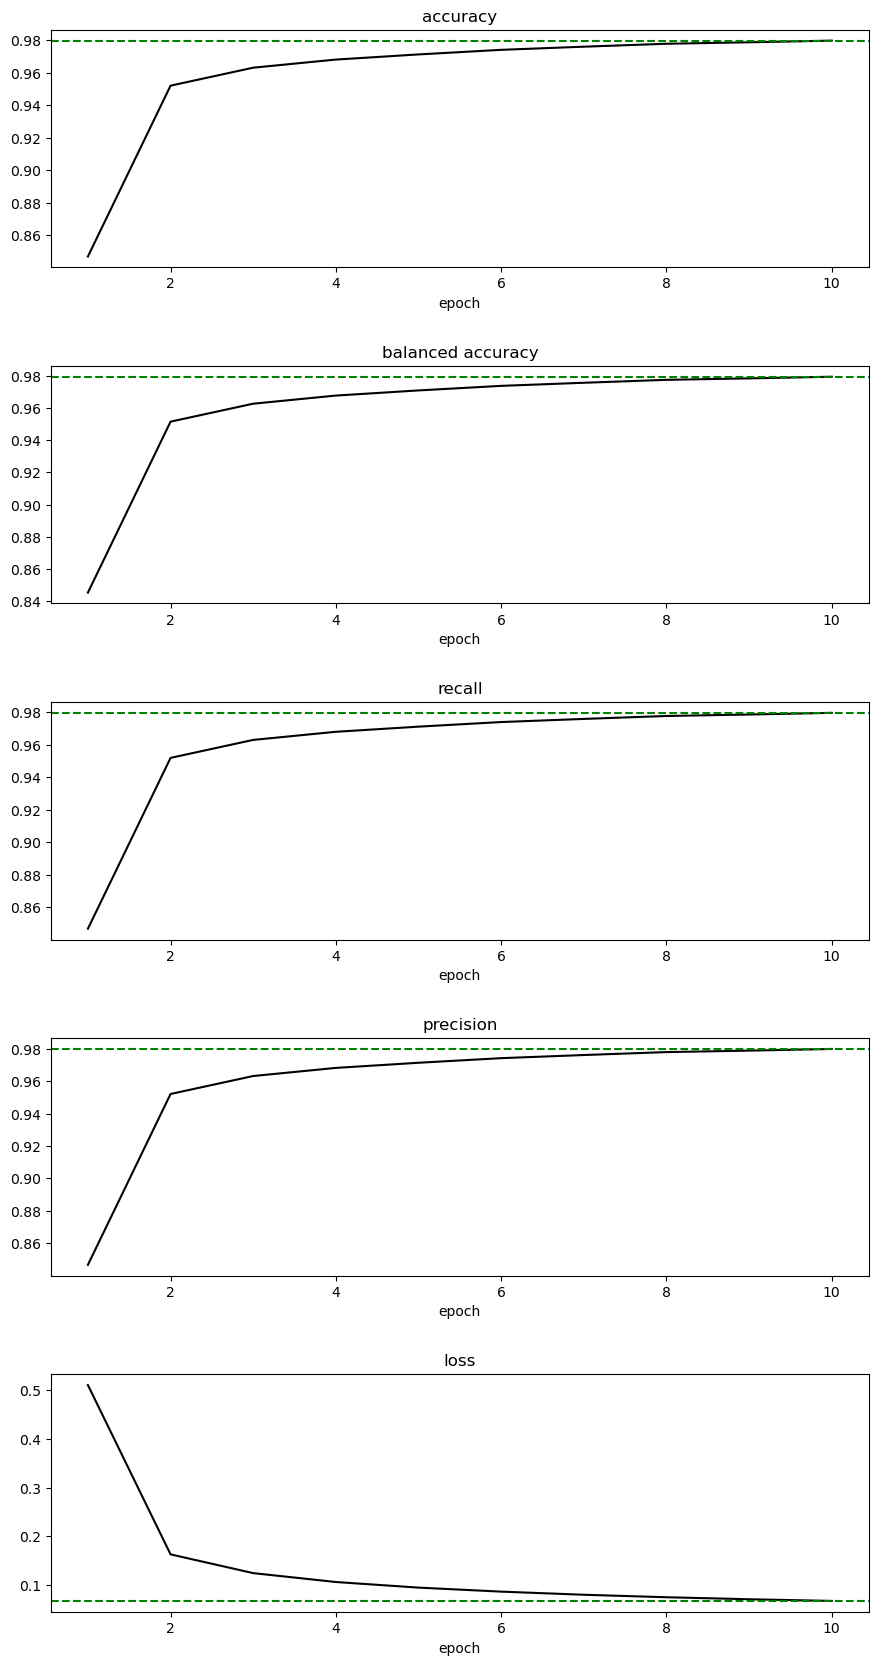

In [12]:
plot_metrics(cfr)

# Making a submission

Make a prediction on test data and save it

In [13]:
test_data = pd.read_csv('data/test.csv')
X_test = test_data.to_numpy().reshape((len(test_data), 28, 28))
X_test = (X_test / 255).astype(np.float32)
prediction = cfr.predict(X_test)

In [14]:
y_pred = pd.DataFrame(prediction, columns=['Label'])
y_pred.index += 1
y_pred['Label'].to_csv('data/submission.csv', index_label='ImageId')

This submission received a score of 0.976 accuracy.

![score](https://raw.githubusercontent.com/Shmuley322/convolutional-neural-network-on-MNIST/main/data/score.PNG)

A model with a similar architecture but with 6 10x10 convolutional kernels (instead of 10 6x6) achieved a score of 0.97271. 

# Discussion

Let's take a look at the kernels:

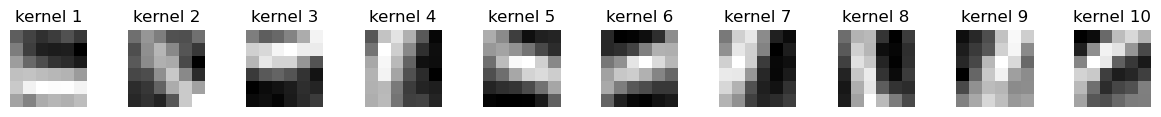

In [15]:
fig, ax = plt.subplots(1, n_kernels, figsize=(n_kernels * 1.5, 1))
for i in range(n_kernels):
    ax[i].imshow(cfr.layers[0].kernel[i,:,:], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'kernel {i + 1}')

As you can see, there are distinct visible features learned by the kernels. 

Overall, the CNN performed slightly better (0.01 score gain) than my [MLP network](https://github.com/Shmuley322/multilayer-perceptron-on-MNIST), however it came at a large cost in training time. In the conclusion to the MLP project I mentioned several ways I could speed up computations. Here is what I've tried with this CNN:

1. CuPy. When I created the network and tested it with numpy I rewrote it for CuPy, created a custom dataloader but training the network on GPU turned out to be as fast as with numpy on CPU at best. After some research, my best guess is that migrating to CuPy only makes sence for large numbers of operations on big matrices, so I reverted to numpy.
2. Numba. During development I found that for each epoch the most time consuming operation by far is matrix multiplication in the forward pass of a linear layer (no idea why, I tried typing each matrix explicitly with float32 but it didn't help). I attempted to optimize that method with numba jit, but was unsuccessful in running it with nopython=True. It was not able to assign explicit types to some variables and my guess is that the np.exp() operation is the problem. I couldn't find a solution in reasonable time and running jit with nopython=False gave no improvement so I abandoned the idea. 

What else could be done: 
1. Hyperparameter tuning. I'm certain that there is an architecture that would produce better results, but the only technique I'm familiar with so far is grid search and I'm already at over 10 minutes per epoch so I will leave it at that. 
2. If I can figure out how to significantly improve training time I can add back multichannel support and in theory this network could be used for any image classification task. 

To sum up, I've not been able to improve training time of the network at all; having said that I'm still pleased with the results and am not currently planning to implement anymore networks from scratch - in my next projects I will be utilizing pytorch. 

Big thanks to [Ahlad Kumar](https://www.youtube.com/@AhladKumar) for his [series](https://www.youtube.com/playlist?list=PLdxQ7SoCLQAMeMPpRvqXJjBSmKey0SdlH) on CNN.